In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak
from numpy import random
import logging

logging.basicConfig(level = logging.INFO)
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)

In [2]:
model_combine = 1

if model_combine == 0:
    model_theta23 = tf.keras.models.load_model('../ML_DUNE/Regression/models_PoissonTrain/0910_theta23_3_1_1.h5')
    model_theta23.summary()
    model_delta = tf.keras.models.load_model('/home/ML4NO/ML_DUNE/Regression/models_PoissonTrain/0910_delta_6_1_1.h5')
    model_delta.summary()
else:
    model_2params = tf.keras.models.load_model('./models_PoissonTrain/0910_2params_2_1_1.h5')
    model_2params.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 144)               0         
_________________________________________________________________
normalization (Normalization (None, 144)               289       
_________________________________________________________________
dense (Dense)                (None, 32)                4640      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16896     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0     

In [3]:
data = np.load('../../Data/sample_NuFit0911.npz')

data_selection = 1 # 0 for all, 1 for lowE(<5GeV), 2 for high(>5GeV)

if data_selection == 0:
    data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif data_selection == 1:
    data_mid = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
elif data_selection == 2:
    data_mid = np.column_stack([data['ve_dune'][:,36:], data['vu_dune'][:,36:], data['vebar_dune'][:,36:], data['vubar_dune'][:,36:]])

data_IO_mid = data_mid[0]
data_NO_mid = data_mid[1]

In [5]:
#No poisson prediction
print('IO prediction = ', model_2params.predict(np.array([data_IO_mid])))
print('NO prediction = ', model_2params.predict(np.array([data_NO_mid])))

IO prediction =  [[ 49.188957 196.26898 ]]
NO prediction =  [[ 49.09027 283.9852 ]]


In [5]:
N = 10000000
data_create_IO = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
data_create_NO = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))

In [6]:
if model_combine == 0:
    pre_create_IO_theta23 = model_theta23.predict(data_create_IO)
    pre_create_NO_theta23 = model_theta23.predict(data_create_NO)
    pre_create_IO_delta = model_delta.predict(data_create_IO)
    pre_create_NO_delta = model_delta.predict(data_create_NO)
else:
    pre_create_IO = model_2params.predict(data_create_IO)
    pre_create_NO = model_2params.predict(data_create_NO)
    pre_create_IO_theta23 = pre_create_IO[:,0][:,np.newaxis]
    pre_create_NO_theta23 = pre_create_NO[:,0][:,np.newaxis]
    pre_create_IO_delta = pre_create_IO[:,1][:,np.newaxis]
    pre_create_NO_delta = pre_create_NO[:,1][:,np.newaxis]

In [9]:
np.savez("./contour_IO/dnn.npz", pre_create_IO)
np.savez("./contour_NO/dnn.npz", pre_create_NO)

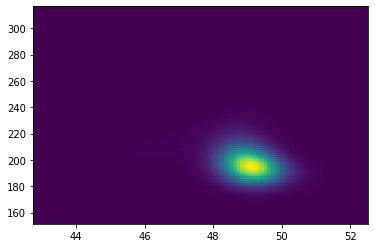

In [ ]:
plt.hist2d(pre_create_IO[:, 0], pre_create_IO[:, 1], bins = 100)
plt.show()

In [ ]:
N_DUNE, N_T2HK, N_DUT2 = 92, 36, 96
theta23_DUNE, delta_cp_DUNE, chi_DUNE = [], [], []
f_DUNE = open("../../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

In [14]:
ordering = 0 # 0 for IO and 1 for NO

if ordering == 0:
    input_theta23 = pre_create_IO_theta23
    input_delta = pre_create_IO_delta
else:
    input_theta23 = pre_create_NO_theta23
    input_delta = pre_create_NO_delta

bins_theta23 = x0
bins_delta = y0
likeliregion, xedges, yedges = np.histogram2d(input_theta23[:, 0], input_delta[:, 0], bins = [bins_theta23,bins_delta])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

Maximum: theta23 [49.1], delta [194.] 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: No contour levels were found within the data range.


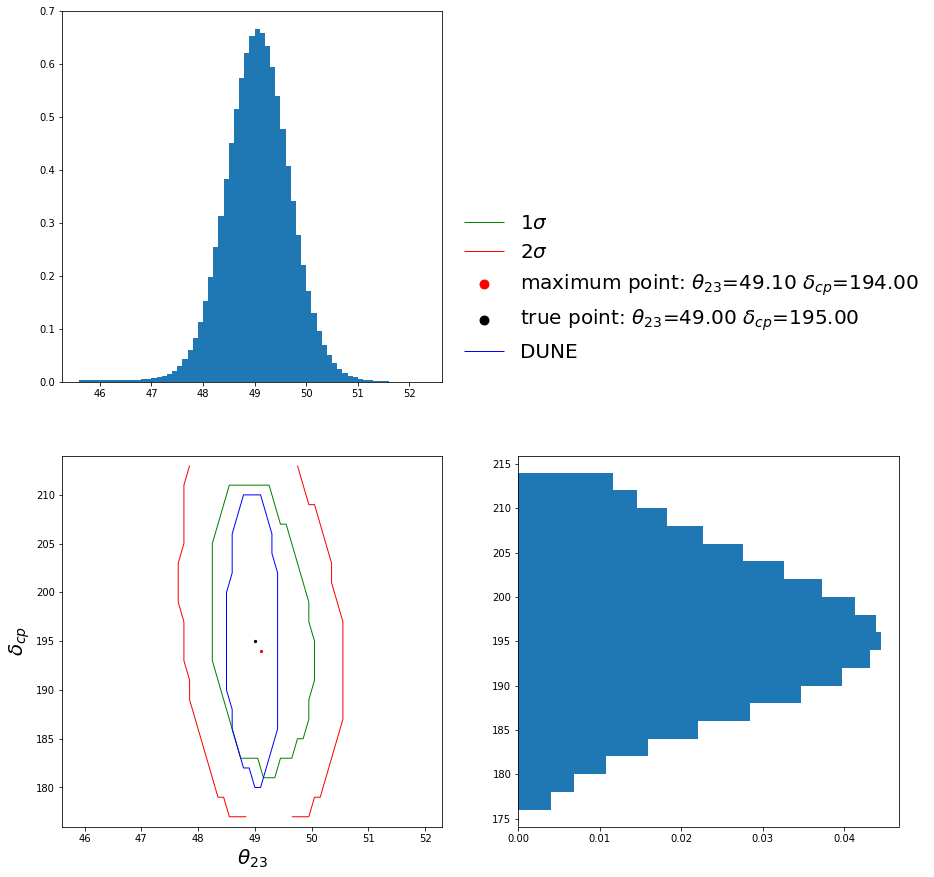

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(pre_create_IO_theta23,density=1,bins=x0)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(pre_create_IO_delta,orientation="horizontal",density=1, bins=y0)

plot_axis = plt.subplot(2,2,3)
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")
plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))
if ordering == 0:plot_axis.scatter(data['theta23'][0], data['delta'][0], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(data['theta23'][0], data['delta'][0]))
else:plot_axis.scatter(data['theta23'][1], data['delta'][1], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(data['theta23'][1], data['delta'][1]))

DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)
DUT2.collections[0].set_label("DUNE")
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()